In [34]:
import scrublet as scr
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import os
from math import ceil
import sklearn.metrics as metrics
import gzip
from pathlib import Path
import pandas as pd
import json
import seaborn as sns
from matplotlib import rcParams
%matplotlib inline

In [2]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rc('font', size=14)
plt.rcParams['pdf.fonttype'] = 42

data_root="/projects/b1042/GoyalLab/zzhang/test/python_data"
locs=[data_root+"/hm-12k/hm-12k",
       data_root+"/J293t-dm/J293t-dm",
       data_root+"/pbmc-2ctrl-dm/pbmc-2ctrl-dm"]

output_dir="/projects/p31666/zzhang/doublet-bchmk/output/scrublet"

In [59]:
root_dir="/projects/p31666/zzhang/doublet-bchmk/data/fatemap_data"
METHOD_ID="scrublet"


all_datasets_dirs=[os.path.join(root_dir, x) for x in next(os.walk(root_dir))[1]]
out_dfs=[]
out_stats=[]
for cur_dataset_dir in all_datasets_dirs:
    cur_out_df, cur_stats=run_scrublet_on_dataset(cur_dataset_dir,METHOD_ID)
    out_dfs.append(cur_out_df)
    out_stats.append(cur_stats)
all_detection_rates_file=os.path.join(root_dir,"output","stats","all_detection_rates.tsv")
all_stats_file=os.path.join(root_dir,"output","stats","all_roc_stats.json")
Path(os.path.join(root_dir,"output","stats")).mkdir(parents=True, exist_ok=True)
all_df=pd.concat(out_dfs)
pd.to_csv(all_output_file, sep="\t", index=False)
flattend_dictionaries={k: v for d in out_stats for k, v in d.items()}
with open(all_stats_file, "w+") as fp:
    json.dump(flattend_dictionaries, fp)

Counts matrix shape: 5672 rows, 32738 columns
Number of genes in gene list: 32738
Estimated multiplet rate: 0.2678067700987306
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.47
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 15.4%
Elapsed time: 10.7 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.59
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 8.0%
	Estimated  = 15.4%
Elapsed time: 10.3 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.67
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 

In [65]:
def run_scrublet_on_dataset(data_dir,METHOD_ID):
    output_dir=os.path.join(data_dir,"doublet_output",METHOD_ID)
    dir_10X=os.path.join(data_dir,"10X")
    dataset_id=data_dir.split('/')[-1]
    sample_dirs=[os.path.join(dir_10X, x) for x in next(os.walk(dir_10X))[1]]
    stats={}
    dfs=[]
    labels_prefix=os.path.join(data_dir,"fatemapID",dataset_id)
    for cur_sample_dir in sample_dirs:
        cur_counts_matrix, cur_estimated_multiplet_rate, cur_labels_to_keep = read_fatemap(cur_sample_dir,labels_prefix)
        cur_data_sample_id="_".join([dataset_id, cur_sample_dir.split("/")[-1]])
        estimated_multiplet_rates_to_test=list(np.arange(0.05,0.20,0.03))
        estimated_multiplet_rates_to_test.append(cur_estimated_multiplet_rate)

        cur_sample_df, cur_stats_dict = run_bchmk(cur_counts_matrix, cur_labels_to_keep, estimated_multiplet_rates_to_test, cur_data_sample_id, output_dir)    
        stats[cur_data_sample_id]=cur_stats_dict
        dfs.append(cur_sample_df)
    out_df=pd.concat(dfs)
    return out_df, stats
    
        

In [66]:
def run_bchmk(counts_matrix, labels, estimated_multiplet_rates_to_test, data_sample_ID, output_dir):
    
    true_singlet_detection_rate=[]
    singlet_in_potential_doublet_detection_rate=[]
    expected_doublet_rate2=[]
    IDs=[]
    roc_auc_ls=[]
    stats_dict={}
    
    for cur_expected_doublet_rate in estimated_multiplet_rates_to_test:
        cur_scrub=scr.Scrublet(counts_matrix, expected_doublet_rate=cur_expected_doublet_rate, random_state=2022)
        doublet_scores, predicted_doublets= cur_scrub.scrub_doublets(min_counts=2, 
                                                              min_cells=3, 
                                                              min_gene_variability_pctl=85, 
                                                              n_prin_comps=30)
        # there are cases where scrub doublets can't automatically detect threshold
        # in this case it's necessary to use call_doublets() with manual threshold
        # I think this is because the data are too similar, not sure why though
        if predicted_doublets is None:
            true_singlet_detection_rate.append(None)
            singlet_in_potential_doublet_detection_rate.append(None)
            roc_auc_ls.append(None)
            expected_doublet_rate2.append(cur_expected_doublet_rate)
            IDs.append(data_sample_ID)
            continue

        
        fpr, tpr, threshold = metrics.roc_curve(y_true=labels, y_score=doublet_scores,pos_label="multiplet")
        roc_auc = metrics.auc(fpr, tpr)
        
        # Of ALL the true singlets, how many of them are correctly labelled as singlets?
        singlet_idx=[idx for idx,label in enumerate(labels) if label=="singlet"]
        singlets_prediction=[predicted_doublets[idx] for idx in singlet_idx]
        singlets_detection_rate=singlets_prediction.count(False)/(len(singlet_idx))
        
        # Of ALL the multiplets, how many of them are labelled as singlets?
        multiplet_idx=[idx for idx,label in enumerate(cur_labels) if label=="multiplet"]
        singlet_in_multiplet_prediction=[predicted_doublets[idx] for idx in multiplet_idx]
        singlets_in_potential_doublets_rate=singlet_in_multiplet_prediction.count(False)/len(multiplet_idx)
        
        true_singlet_detection_rate.append(singlets_detection_rate)
        singlet_in_potential_doublet_detection_rate.append(singlets_in_potential_doublets_rate)
        expected_doublet_rate2.append(cur_expected_doublet_rate)
        IDs.append(data_sample_ID)
        roc_auc_ls.append(roc_auc)
        
        # save doublets predictions
        doublets_predictions_df=pd.DataFrame({
            "fatemap_label":labels,
            "prediction_label":predicted_doublets,
            "prediction_score":doublet_scores
        })
        out_file=os.path.join(output_dir, "{}_{:.2f}_doublets_predictions.tsv".format(data_sample_ID, cur_expected_doublet_rate))
        Path(output_dir).mkdir(parents=True, exist_ok=True)
        doublets_predictions_df.to_csv(out_file, sep="\t", index=False)
        
        stats_key="{}_{:.2f}".format(data_sample_ID, cur_expected_doublet_rate)
        stats_dict[stats_key]=[fpr,tpr,roc_auc]
    # format output dataframe
    df=pd.DataFrame({
        "ID":IDs,
        'Expected_Doublet_Rate':expected_doublet_rate2,
        'True_Singlet_Detection_Rate':true_singlet_detection_rate,
        'Singet_in_Potential_Doublet_Detection_Rate':singlet_in_potential_doublet_detection_rate,
        'ROC_AUC':roc_auc_ls
    })
    df=df.sort_values(by=['Expected_Doublet_Rate'])
    
    return df, stats_dict

In [34]:
def read_fatemap(prefix,cell_labels_prefix):
    cell_id_file=prefix+"/barcodes.tsv.gz"
    gene_id_file=prefix+"/features.tsv.gz"
    mtx=prefix+"/matrix.mtx.gz"
    singlets_file=cell_labels_prefix+"_singlets.txt"
    multiplets_file=cell_labels_prefix+"_multiplets.txt"
    with open(singlets_file) as fp:
        singlets=[x.strip("\n") for x in fp.readlines()]
    singlets=np.array([x+"-1" for x in singlets])
    with open(multiplets_file) as fp:
        multiplets=np.array([x.strip("\n") for x in fp.readlines()])
    multiplets=np.array([x+"-1" for x in multiplets])
    with gzip.open(cell_id_file) as fp:
        cell_ids=np.array([x.decode('UTF-8').strip("\n") for x in fp.readlines()])
    labels=["singlet" if x in singlets else "multiplet" if x in multiplets else "NA" for x in cell_ids]
    idx_to_keep=[idx for idx, item in enumerate(labels) if item!="NA"]
    labels_to_keep=[labels[idx] for idx in idx_to_keep]
    counts_matrix=scipy.io.mmread(mtx).T.tocsc()[idx_to_keep,:]
    estimated_multiplet_rate=labels.count("multiplet")/(labels.count("multiplet")+labels.count("singlet"))

    with gzip.open(gene_id_file) as fp:
        gene_IDs=[x.decode('UTF-8').strip("\n") for x in fp.readlines()]
    print('Counts matrix shape: {} rows, {} columns'.format(counts_matrix.shape[0], counts_matrix.shape[1]))
    print('Number of genes in gene list: {}'.format(len(gene_IDs)))
    print('Estimated multiplet rate: {}'.format(estimated_multiplet_rate))
    
    # cur_scrub=scr.Scrublet(counts_matrix, expected_doublet_rate=estimated_multiplet_rate, random_state=2022)
    return counts_matrix,estimated_multiplet_rate,labels_to_keep

In [11]:
def read_bchmk_dblt_data_as_scrub(prefix):
    cell_id_file=prefix+"_cell-ID.txt"
    gene_id_file=prefix+"_genes.txt"
    mtx=prefix+"_data.mtx"
    labels=prefix+"_doublets-labels.txt"
    counts_matrix=scipy.io.mmread(mtx).T.tocsc()
    with open(labels) as fp:
        labels=np.array([x.strip("\n") for x in fp.readlines()])
    estimated_doublet_rate=len(labels[labels=="doublet"])/len(labels)
    estimated_doublet_rate=ceil(estimated_doublet_rate * 100) / 100.0
    with open(gene_id_file) as fp:
        gene_IDs=[x.strip("\n") for x in fp.readlines()]
    print('Counts matrix shape: {} rows, {} columns'.format(counts_matrix.shape[0], counts_matrix.shape[1]))
    print('Number of genes in gene list: {}'.format(len(gene_IDs)))
    print('Estimated doublet rate: {}'.format(estimated_doublet_rate))
    return estimated_doublet_rate,counts_matrix,labels

In [43]:
plots={}
for cur_loc in locs:
    estimated_doublet_rate,cur_counts_matrix,labels=read_bchmk_dblt_data_as_scrub(cur_loc)
    cur_scrub=scr.Scrublet(cur_counts_matrix, expected_doublet_rate=estimated_doublet_rate, random_state=2022)
    doublet_scores, predicted_doublets= cur_scrub.scrub_doublets(min_counts=2, 
                                                          min_cells=3, 
                                                          min_gene_variability_pctl=85, 
                                                          n_prin_comps=30)
    fpr, tpr, threshold = metrics.roc_curve(y_true=labels, y_score=doublet_scores,pos_label="doublet")
    roc_auc = metrics.auc(fpr, tpr)
    cur_data_id=cur_loc.split('/')[-1]
    plots[cur_data_id]=[fpr,tpr,roc_auc]
    print("<==========================================>")

Counts matrix shape: 12820 rows, 15106 columns
Number of genes in gene list: 15106
Estimated doublet rate: 0.06
Preprocessing...


/home/zzj4347/softwares/anaconda3/envs/doublet-bchmk/lib/python3.7/site-packages/scrublet/helper_functions.py:241: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.24
Detected doublet rate = 4.6%
Estimated detectable doublet fraction = 55.2%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 8.4%
Elapsed time: 21.5 seconds
<==========================================>
Counts matrix shape: 500 rows, 16374 columns
Number of genes in gene list: 16374
Estimated doublet rate: 0.09
Preprocessing...
Simulating doublets...


/home/zzj4347/softwares/anaconda3/envs/doublet-bchmk/lib/python3.7/site-packages/scrublet/helper_functions.py:241: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])


Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.0%
Estimated detectable doublet fraction = 46.6%
Overall doublet rate:
	Expected   = 9.0%
	Estimated  = 2.1%
Elapsed time: 0.4 seconds
<==========================================>
Counts matrix shape: 13913 rows, 17584 columns
Number of genes in gene list: 17584
Estimated doublet rate: 0.12
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.30
Detected doublet rate = 8.1%
Estimated detectable doublet fraction = 54.9%
Overall doublet rate:
	Expected   = 12.0%
	Estimated  = 14.8%
Elapsed time: 18.0 seconds
<==========================================>


/home/zzj4347/softwares/anaconda3/envs/doublet-bchmk/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  after removing the cwd from sys.path.
/home/zzj4347/softwares/anaconda3/envs/doublet-bchmk/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  after removing the cwd from sys.path.
/home/zzj4347/softwares/anaconda3/envs/doublet-bchmk/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  after removing the cwd from sys.path.


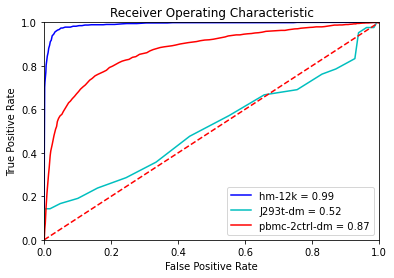

In [50]:
plt.title('Receiver Operating Characteristic')
colors=['b','c','r','y']
for idx,data_id in enumerate(plots.keys()):
    plt.plot(plots[data_id][0], plots[data_id][1], 'b', label = '%s = %0.2f' % (data_id,plots[data_id][2]),c=colors[idx])
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Visualize results

In [18]:
all_detection_rates_df=pd.read_csv("/projects/p31666/zzhang/doublet-bchmk/data/fatemap_data/output/stats/all_detection_rates.tsv",sep="\t")

In [21]:
all_detection_rates_df["Detection_Rate_Diff_in_Two_Categories"]=all_detection_rates_df["True_Singlet_Detection_Rate"]-all_detection_rates_df["Singet_in_Potential_Doublet_Detection_Rate"]

In [22]:
all_detection_rates_df.head(30)

,ID,Expected_Doublet_Rate,True_Singlet_Detection_Rate,Singet_in_Potential_Doublet_Detection_Rate,ROC_AUC,Detection_Rate_Diff_in_Two_Categories
0,FM04_BC18_B1,0.050000,0.999759,1.000000,0.531608,-0.000241
1,FM04_BC18_B1,0.060000,0.999759,1.000000,0.531608,-0.000241
2,FM04_BC18_B1,0.070000,0.999759,1.000000,0.531608,-0.000241
3,FM04_BC18_B1,0.080000,0.999759,1.000000,0.531608,-0.000241
4,FM04_BC18_B1,0.090000,0.999759,1.000000,0.531608,-0.000241
5,FM04_BC18_B1,0.100000,0.999759,1.000000,0.531608,-0.000241
6,FM04_BC18_B1,0.110000,0.999759,1.000000,0.531608,-0.000241
7,FM04_BC18_B1,0.120000,0.999759,1.000000,0.531608,-0.000241
8,FM04_BC18_B1,0.130000,0.999759,1.000000,0.531608,-0.000241
9,FM04_BC18_B1,0.140000,0.999759,1.000000,0.531608,-0.000241


<AxesSubplot:xlabel='Expected_Doublet_Rate', ylabel='Detection_Rate_Diff_in_Two_Categories'>

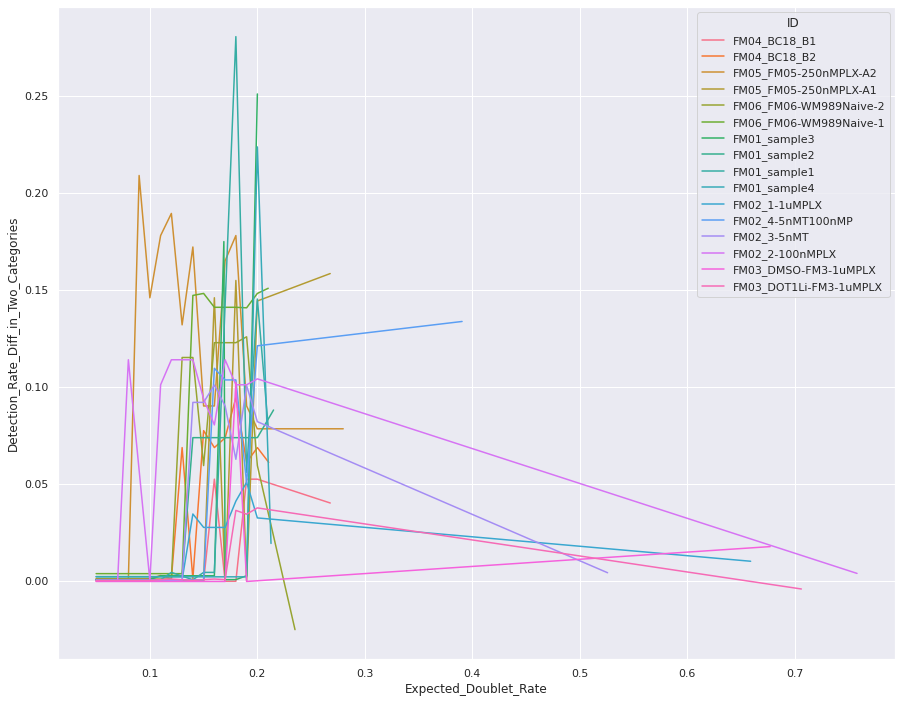

In [36]:
rcParams['figure.figsize'] = 15,12

sns.lineplot(data=all_detection_rates_df, x="Expected_Doublet_Rate", y="Detection_Rate_Diff_in_Two_Categories",hue="ID")

<AxesSubplot:xlabel='Expected_Doublet_Rate', ylabel='True_Singlet_Detection_Rate'>

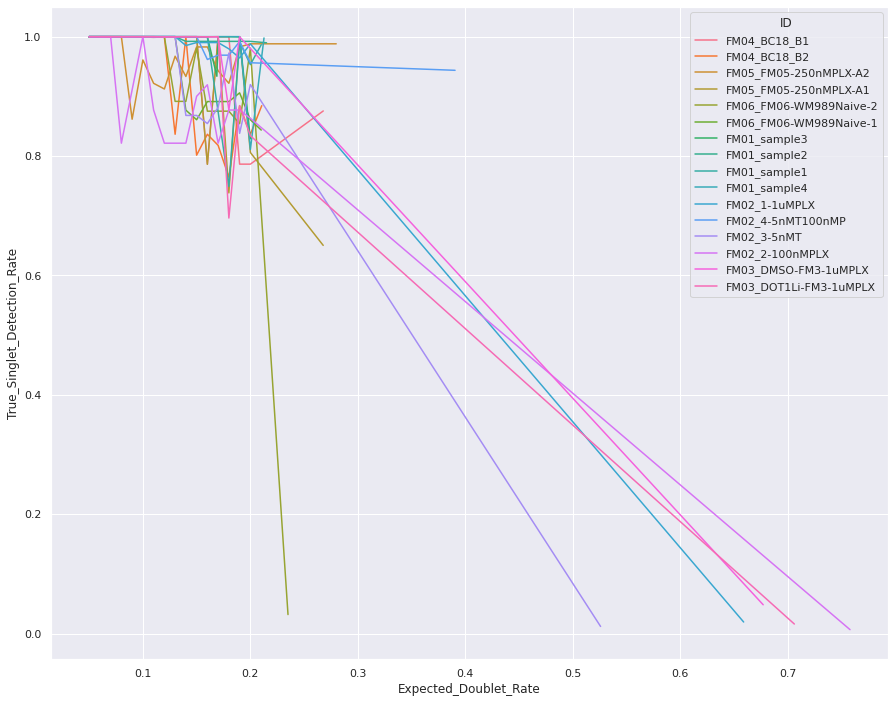

In [37]:
sns.lineplot(data=all_detection_rates_df, x="Expected_Doublet_Rate", y="True_Singlet_Detection_Rate",hue="ID")

<AxesSubplot:xlabel='Expected_Doublet_Rate', ylabel='Singet_in_Potential_Doublet_Detection_Rate'>

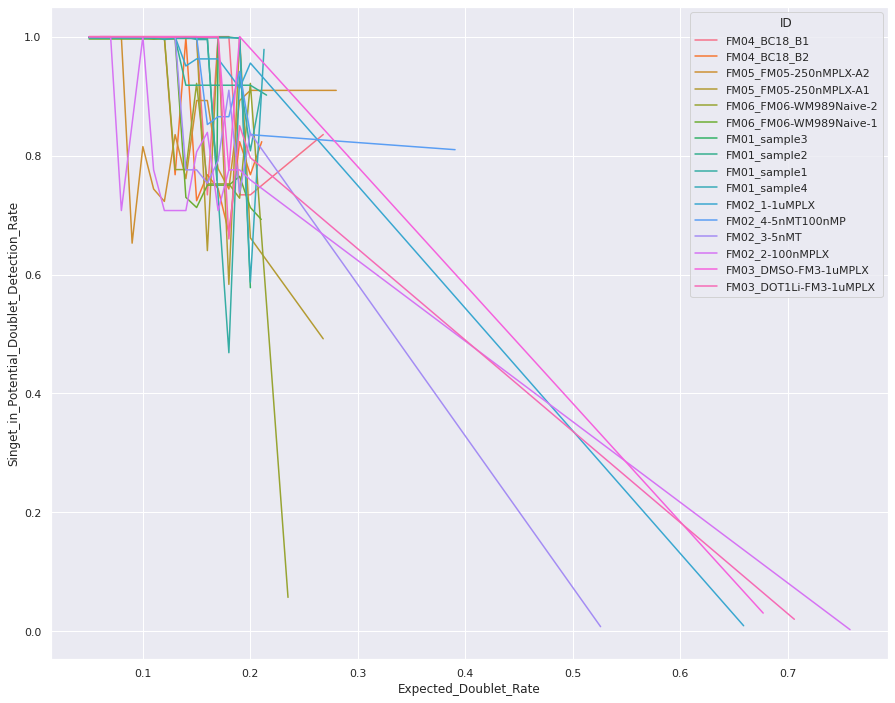

In [38]:
sns.lineplot(data=all_detection_rates_df, x="Expected_Doublet_Rate", y="Singet_in_Potential_Doublet_Detection_Rate",hue="ID")

In [39]:
detection_eight_percent=all_detection_rates_df[all_detection_rates_df["Expected_Doublet_Rate"]==0.08]
detection_eight_percent

,ID,Expected_Doublet_Rate,True_Singlet_Detection_Rate,Singet_in_Potential_Doublet_Detection_Rate,ROC_AUC,Detection_Rate_Diff_in_Two_Categories
3,FM04_BC18_B1,0.08,0.999759,1.000000,0.531608,-0.000241
20,FM04_BC18_B2,0.08,0.999402,0.998317,0.604101,0.001084
37,FM05_FM05-250nMPLX-A2,0.08,1.000000,0.999305,0.656097,0.000695
54,FM05_FM05-250nMPLX-A1,0.08,0.999876,0.999660,0.609470,0.000216
71,FM06_FM06-WM989Naive-2,0.08,0.999836,0.998930,0.572242,0.000905
88,FM06_FM06-WM989Naive-1,0.08,0.999697,0.996009,0.594440,0.003688
105,FM01_sample3,0.08,0.999845,0.999237,0.673206,0.000608
122,FM01_sample2,0.08,1.000000,0.997831,0.667759,0.002169
139,FM01_sample1,0.08,0.999814,0.999302,0.684213,0.000513
156,FM01_sample4,0.08,1.000000,0.997957,0.658955,0.002043
